In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/home/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [82]:
device = torch.device("cpu")
dtype = torch.float64

In [83]:
L = 45
q = 4
n_rounds = 3
n_chains = 10**3

chains_init = training.init_chains(n_rounds, n_chains, L, q, device, dtype)

In [84]:
k = torch.randn(L, q, dtype=dtype, device=device)
h = torch.randn(L, q, dtype=dtype, device=device)

tr = tree.Tree()
tr.add_node(-1)
tr.add_node(0)

selected_modes = torch.BoolTensor([[1],[1]]).to(device)

Ns0 = energy_models.IndepSites(k)
indep = energy_models.IndepSites(h)
ps = selex_distribution.MultiModeDistribution(indep, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [85]:
t = 1

h_eff = k + t * h
indep_eff = energy_models.IndepSites(h_eff)
e_avg = indep_eff.avg_energy().item()
e_avg

-52.149972431593895

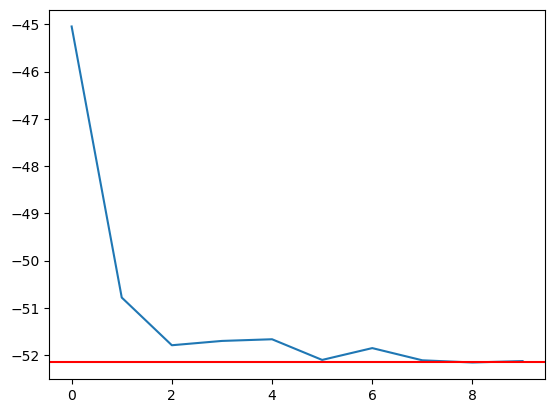

In [86]:
es = []
chains = chains_init.clone()
for _ in range(10):
    e = sampling.sample_metropolis(model, chains, t, n_sweeps)
    es.append(e.mean().item())
plt.plot(es)
plt.axhline(e_avg, color='r')

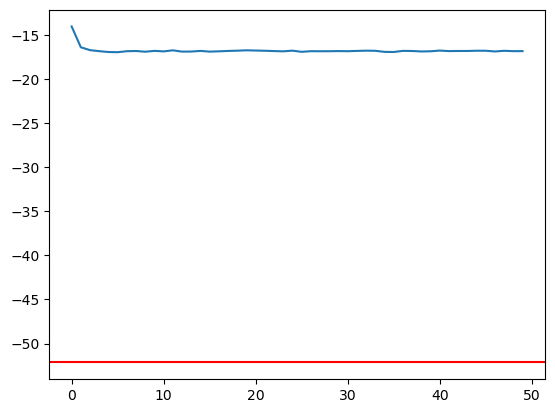

In [90]:
es = []
chains = chains_init.clone()
for _ in range(50):
    model.sample_metropolis_uniform_sites(chains, t, n_sweeps)
    e = model.compute_energy_up_to_round(chains, t)
    es.append(e.mean().item())
plt.plot(es)
plt.axhline(e_avg, color='r')

In [64]:
k = torch.randn(L, q, dtype=dtype, device=device)
h = torch.randn(L, q, dtype=dtype, device=device)
J = torch.randn(L, q, L, q, dtype=dtype, device=device)

tr = tree.Tree()
tr.add_node(-1)
tr.add_node(0)

selected_modes = torch.BoolTensor([[1],[1]]).to(device)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
indep = energy_models.IndepSites(h)
ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [65]:
# model.metropolis_sampler_gpu(chains_init, t, n_sweeps=2000);

In [66]:
chains = chains_init.clone()

In [67]:
t = 1
n_sweeps = 10

e = model.metropolis_sampler_gpu(chains, t, n_sweeps)
e2 = model.compute_energy_up_to_round(chains[t], t)
assert (e - e2).abs().max() < 1e-10
e_avg = e.mean()
e_avg

tensor(-176.8902, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [68]:
chains = chains_init.clone()

In [69]:
t = 1
n_sweeps = 10

model.sample_metropolis_uniform_sites(chains, t, n_sweeps)
e = model.compute_energy_up_to_round(chains[t], t)
e_avg = e.mean()
e_avg

tensor(-177.3800, dtype=torch.float64, grad_fn=<MeanBackward0>)

Benchmark

In [70]:
import importlib
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(sampling)

<module 'sampling' from '/home/scrotti/Aptamer2025py/sampling.py'>

In [72]:
t = 1
n_sweeps = 10

%timeit sampling.sample_metropolis(model, chains, t, n_sweeps)

172 ms ± 5.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
t = 1
n_sweeps = 10

%timeit model.sample_metropolis_uniform_sites(chains, t, n_sweeps)

249 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%load_ext line_profiler

In [75]:
%lprun -f sampling._sample_metropolis sampling.sample_metropolis(model, chains_init, t, n_sweeps)

Timer unit: 1e-09 s

Total time: 0.171221 s
File: /home/scrotti/Aptamer2025py/sampling.py
Function: _sample_metropolis at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def _sample_metropolis(model, chains, t, n_steps, beta = 1.0):
     4         1       2754.0   2754.0      0.0      B, L, q = chains.shape
     5         1       1933.0   1933.0      0.0      device = chains.device
     6         1    2020873.0 2.02e+06      1.2      e_current = model.compute_energy_up_to_round(chains, t)
     7                                           
     8       226      75714.0    335.0      0.0      for _ in range(n_steps):
     9       225    1458171.0   6480.8      0.9          proposal_flip_indices = torch.randint(0, L, (B,), device=device)
    10       225    1206546.0   5362.4      0.7          proposal_new_tokens = torch.randint(0, q, (B,), device=device)
    11                                                   
    12

GPU

In [76]:
device = torch.device('cuda')

In [77]:
k = torch.randn(L, q, dtype=dtype, device=device)
h = torch.randn(L, q, dtype=dtype, device=device)
J = torch.randn(L, q, L, q, dtype=dtype, device=device)

tr = tree.Tree()
tr.add_node(-1)
tr.add_node(0)

selected_modes = torch.BoolTensor([[1],[1]]).to(device)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
indep = energy_models.IndepSites(h)
ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [78]:
chains = chains_init.clone().to(device)

In [81]:
t = 1
n_sweeps = 5

%timeit sampling.sample_metropolis(model, chains, t, n_sweeps)

60.2 ms ± 21.1 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
